导入图片需要更改：
1. 角点个数
2. 文件夹名称
3. 世界坐标系的圆心点距离
4. 确定是棋盘格还是圆心标定板

In [2]:

import cv2

import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
 
import sys
import numpy as np
import glob
class shuangmu:
    def __init__(self):
        self.m1 = 0
        self.m2 = 0
        self.d1 = 0
        self.d2 = 0
        self.R = 0
        self.T = 0
stereo = shuangmu()

class StereoCalibration(object):
    def __init__(self):
        self.imagesL = self.read_images('camL')
        self.imagesR = self.read_images('camR')
        
    def read_images(self , cal_path):
        filepath = glob.glob(cal_path + '/*.bmp')
        filepath.sort()
        return filepath
    #标定图像
    def calibration_photo(self):
        #设置要标定的角点个数
        x_nums = 7                                                   #x方向上的角点个数
        y_nums = 7
        # 设置(生成)标定图在世界坐标中的坐标
        world_point = np.zeros((x_nums * y_nums,3),np.float32)            #生成x_nums*y_nums个坐标，每个坐标包含x,y,z三个元素
        world_point[:,:2] = np.mgrid[:x_nums,:y_nums].T.reshape(-1, 2)    #mgrid[]生成包含两个二维矩阵的矩阵，每个矩阵都有x_nums列,y_nums行
                                                                            #.T矩阵的转置
                                                                            #reshape()重新规划矩阵，但不改变矩阵元素
        #保存角点坐标
        world_position = []
        image_positionl = []
        image_positionr = []
        #设置角点查找限制
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,30,0.001)
        #获取所有标定图
        for ii in range(20):

            image_path_l = self.imagesL[ii]
            image_path_r = self.imagesR[ii]

            image_l = cv2.imread(image_path_l)
            image_r = cv2.imread(image_path_r)
            gray_l = cv2.cvtColor(image_l,cv2.COLOR_RGB2GRAY)
            gray_r = cv2.cvtColor(image_r,cv2.COLOR_RGB2GRAY)

            #查找角点
    #         ok,corners = cv2.findChessboardCorners(gray,(x_nums,y_nums),None)
#             ok1,cornersl = cv2.findChessboardCorners(gray_l,(x_nums,y_nums),None)
#             ok2,cornersr = cv2.findChessboardCorners(gray_r,(x_nums,y_nums),None)
            ok1,cornersl = cv2.findCirclesGrid(gray_l,(x_nums,y_nums),None)
            ok2,cornersr = cv2.findCirclesGrid(gray_r,(x_nums,y_nums),None)
            
            self.world = world_point
#             print(ok1&ok2)
            if ok1&ok2:
                #把每一幅图像的世界坐标放到world_position中
                center_spacing = 15     ## 圆心的位置距离，这一个其实不重要
                world_position.append(world_point*center_spacing)
                #获取更精确的角点位置
                exact_cornersl = cv2.cornerSubPix(gray_l,cornersl,(11,11),(-1,-1),criteria)
                exact_cornersr = cv2.cornerSubPix(gray_r,cornersr,(11,11),(-1,-1),criteria)
                #把获取的角点坐标放到image_position中
                image_positionl.append(exact_cornersl)
                image_positionr.append(exact_cornersr)
                #可视化角点
    #             image = cv2.drawChessboardCorners(image,(x_nums,y_nums),exact_corners,ok)
    #             cv2.imshow('image_corner',image)
    #             cv2.waitKey(0)
        #计算内参数
        image_shape = gray_l.shape[::-1]
        
        retl, mtxl, distl, rvecsl, tvecsl = cv2.calibrateCamera(world_position, image_positionl, image_shape , None,None)
        retr, mtxr, distr, rvecsr, tvecsr = cv2.calibrateCamera(world_position, image_positionr, image_shape , None,None)
        print('left camera\'s K  = ',mtxl)
        print('right camera\'s K = ',mtxr)
        print('left camera\'s distort = ' , distl)
        print('right camera\'s distort = ' , distr)
        stereo.m1 = mtxl
        stereo.m2 = mtxr
        stereo.d1 = distl
        stereo.d2 = distr
        
        
        #计算误差
        self.cal_error(world_position , image_positionl ,  mtxl , distl , rvecsl , tvecsl)
        self.cal_error(world_position , image_positionr ,  mtxr,  distr , rvecsr , tvecsr)

        ##双目标定
        self.stereo_calibrate( world_position ,image_positionl , image_positionr , mtxl, distl, mtxr, distr, image_shape)
        
    def cal_error(self , world_position , image_position ,  mtx , dist , rvecs , tvecs):
        #计算偏差
        mean_error = 0
        for i in range(len(world_position)):
            image_position2, _ = cv2.projectPoints(world_position[i], rvecs[i], tvecs[i], mtx, dist)
            error = cv2.norm(image_position[i], image_position2, cv2.NORM_L2) / len(image_position2)
            mean_error += error
        print("total error: ", mean_error / len(image_position))

    def stereo_calibrate( self ,  objpoints ,imgpoints_l , imgpoints_r , M1, d1, M2, d2, dims):
        flags = 0
        flags |= cv2.CALIB_FIX_INTRINSIC
        flags |= cv2.CALIB_USE_INTRINSIC_GUESS
        flags |= cv2.CALIB_FIX_FOCAL_LENGTH
        flags |= cv2.CALIB_ZERO_TANGENT_DIST
        stereocalib_criteria = (cv2.TERM_CRITERIA_MAX_ITER +cv2.TERM_CRITERIA_EPS, 100, 1e-5)
        ret, M1, d1, M2, d2, R, T, E, F = cv2.stereoCalibrate(
                                    objpoints, imgpoints_l,
                                    imgpoints_r, M1, d1, M2,
                                    d2, dims,
                                    criteria=stereocalib_criteria, flags=flags)
        print('R = ',R)
        print('T = ',T)
        stereo.R = R
        stereo.T = T
        
if __name__ == '__main__':
#     calibration_photo()
    np.set_printoptions(precision=5, suppress=True)
    biaoding = StereoCalibration()
    biaoding.calibration_photo()

left camera's K  =  [[2158.66436    0.       663.3482 ]
 [   0.      2158.75332  521.60097]
 [   0.         0.         1.     ]]
right camera's K =  [[2156.96974    0.       609.71291]
 [   0.      2158.65266  532.00808]
 [   0.         0.         1.     ]]
left camera's distort =  [[ -0.03706   1.35135   0.00024   0.00197 -10.94371]]
right camera's distort =  [[ 0.00666 -0.49887  0.00156  0.00093  8.74557]]
total error:  0.02552895315013799
total error:  0.028725163900975837
R =  [[ 0.85431 -0.00472  0.51974]
 [ 0.00609  0.99998 -0.00094]
 [-0.51972  0.00397  0.85432]]
T =  [[-289.43628]
 [  -6.46068]
 [  52.29194]]


从这里看到，圆板的中心点距离为15mm，所以相机的基线的长度为289mm左右。
另外双目之间的旋转矩阵有一些异常，旋转量过大。说明双目所看的方向不太平行，最终导致的结果就是：立体几何校正之后出现图片拼接错误的情况。
![20200610082320](https://chendaxiashizhu-1259416116.cos.ap-beijing.myqcloud.com/20200610082320.png)

In [3]:
# 将双目参数保存到这个结构体中，方便调用
import numpy as np
import cv2

#双目相机参数
class stereoCameral(object):
    def __init__(self):
        #左相机内参数
        self.cam_matrix_left = stereo.m1
        #右相机内参数
        self.cam_matrix_right = stereo.m2

        #左右相机畸变系数:[k1, k2, p1, p2, k3]
        self.distortion_l = stereo.d1
        self.distortion_r = stereo.d2
        #旋转矩阵
        
        self.R = stereo.R
#         self.R = np.array([[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]])
        #平移矩阵
        self.T = stereo.T
        self.T = np.array([[-293.835],
                         [  -7.334],
                         [  52.816]])
        
        self.baseline = stereo.T[0]

#### 去畸变、立体几何校正
这里问题是：
- 基线这个量好像没什么用，当然，主要是和旋转矩阵相关
- 为什么经过几何校正之后结果这么奇怪？就是因为视差比较大吗？

R1 =  [[ 0.93265  0.01921  0.36027]
 [-0.01761  0.99982 -0.00773]
 [-0.36035  0.00087  0.93282]]
R1 =  [[ 0.98393  0.02456 -0.17686]
 [-0.02378  0.9997   0.00651]
 [ 0.17696 -0.0022   0.98421]]
P1 =  [[2158.70299    0.      -248.65393    0.     ]
 [   0.      2158.70299  529.81726    0.     ]
 [   0.         0.         1.         0.     ]]
P2 =  [[   2158.70299       0.         1034.00797 -644662.32119]
 [      0.         2158.70299     529.81726       0.     ]
 [      0.            0.            1.            0.     ]]
1280 1024


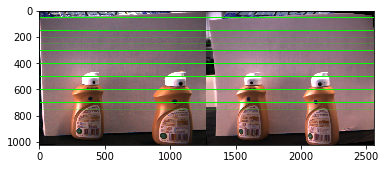

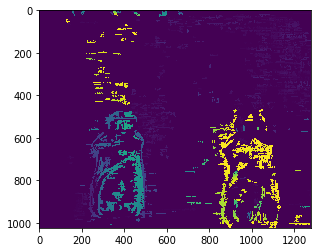

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片

# 预处理
def preprocess(img1, img2):
    # 彩色图->灰度图
    im1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    im2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
 
    # 直方图均衡
    im1 = cv2.equalizeHist(im1)
    im2 = cv2.equalizeHist(im2)
 
    return im1, im2

# 消除畸变
def undistortion(image, camera_matrix, dist_coeff):
    undistortion_image = cv2.undistort(image, camera_matrix, dist_coeff)
 
    return undistortion_image
 
# 获取畸变校正和立体校正的映射变换矩阵、重投影矩阵
# @param：config是一个类，存储着双目标定的参数:config = stereoconfig.stereoCamera()

def getRectifyTransform(height, width, config):
    # 读取内参和外参
    left_K = config.cam_matrix_left
    right_K = config.cam_matrix_right
    left_distortion = config.distortion_l
    right_distortion = config.distortion_r
    R = config.R
    T = config.T
# #     
#     R = np.transpose(config.R)
#     T = -np.dot(np.transpose(config.R),config.T)

    # 计算校正变换
    height = int(height)
    width = int(width)
    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(left_K, left_distortion, right_K, right_distortion, (width, height), R, T,flags=0, alpha=-1)
    print('R1 = ',R1)
    print('R1 = ',R2)
    print('P1 = ',P1)
    print('P2 = ',P2)
 
#     map1x, map1y = cv2.initUndistortRectifyMap(left_K, left_distortion, R1, P1, (width, height), cv2.CV_16SC2)
#     map2x, map2y = cv2.initUndistortRectifyMap(right_K, right_distortion, R2, P2, (width, height), cv2.CV_16SC2)
    map1x, map1y = cv2.initUndistortRectifyMap(left_K, left_distortion, R1, P1, (width, height), cv2.CV_32FC1)
    map2x, map2y = cv2.initUndistortRectifyMap(right_K, right_distortion, R2, P2, (width, height), cv2.CV_32FC1)
    
    print(width,height)
 
    return map1x, map1y, map2x, map2y, Q
 
 
# 畸变校正和立体校正
def rectifyImage(image1, image2, map1x, map1y, map2x, map2y):
    rectifyed_img1 = cv2.remap(image1, map1x, map1y, cv2.INTER_LINEAR)
    rectifyed_img2 = cv2.remap(image2, map2x, map2y, cv2.INTER_LINEAR)
 
    return rectifyed_img1, rectifyed_img2
 
# 立体校正检验----画线
def draw_line1(image1, image2):
    # 建立输出图像
    height = max(image1.shape[0], image2.shape[0])
    width = image1.shape[1] + image2.shape[1]
    
    output = np.zeros((height, width,3), dtype=np.uint8)
    output[0:image1.shape[0], 0:image1.shape[1]] = image1
    output[0:image2.shape[0], image1.shape[1]:] = image2
 
    for k in range(15):
        cv2.line(output, (0, 50 * (k + 1)), (2 * width, 50 * (k + 1)), (0, 255, 0), thickness=2, lineType=cv2.LINE_AA)  # 直线间隔：100
 
    return output
# 立体校正检验----画线
def draw_line2(image1, image2):
    # 建立输出图像
    height = max(image1.shape[0], image2.shape[0])
    width = image1.shape[1] + image2.shape[1]
    
    output = np.zeros((height, width), dtype=np.uint8)
    output[0:image1.shape[0], 0:image1.shape[1]] = image1
    output[0:image2.shape[0], image1.shape[1]:] = image2
 
    for k in range(15):
        cv2.line(output, (0, 50 * (k + 1)), (2 * width, 50 * (k + 1)), (0, 255, 0), thickness=2, lineType=cv2.LINE_AA)  # 直线间隔：100
 
    return output
# 视差计算
def disparity_SGBM(left_image, right_image, down_scale=False):
    # SGBM匹配参数设置
    if left_image.ndim == 2:
        img_channels = 1
    else:
        img_channels = 3
    blockSize = 3
    param = {'minDisparity': 0,
             'numDisparities': 128,
             'blockSize': blockSize,
             'P1': 8 * img_channels * blockSize ** 2,
             'P2': 32 * img_channels * blockSize ** 2,
             'disp12MaxDiff': 1,
             'preFilterCap': 63,
             'uniquenessRatio': 15,
             'speckleWindowSize': 100,
             'speckleRange': 2,
             'mode': cv2.STEREO_SGBM_MODE_SGBM_3WAY
             }
 
    # 构建SGBM对象
    sgbm = cv2.StereoSGBM_create(**param)
 
    # 计算视差图
    size = (left_image.shape[1], left_image.shape[0])
    if down_scale == False:
        disparity_left = sgbm.compute(left_image, right_image)
        disparity_right = sgbm.compute(right_image, left_image)
    else:
        left_image_down = cv2.pyrDown(left_image)
        right_image_down = cv2.pyrDown(right_image)
        factor = size[0] / left_image_down.shape[1]
        disparity_left_half = sgbm.compute(left_image_down, right_image_down)
        disparity_right_half = sgbm.compute(right_image_down, left_image_down)
        disparity_left = cv2.resize(disparity_left_half, size, interpolation=cv2.INTER_AREA) 
        disparity_right = cv2.resize(disparity_right_half, size, interpolation=cv2.INTER_AREA)
        disparity_left *= factor 
        disparity_right *= factor
 
    return disparity_left, disparity_right

if __name__ == '__main__':
    
    imgL = cv2.imread("pingzi_L.bmp")
    imgR = cv2.imread("pingzi_R.bmp")
#     imgL = cv2.imread("camL/L3.bmp")
#     imgR = cv2.imread("camR/R3.bmp")
#     imgL , imgR = preprocess(imgL ,imgR )
    
    ## 变成灰度图（to do）
    
    
    height, width = imgL.shape[0:2]
    config = stereoCameral()    # 读取相机内参和外参
    
    # 去畸变
    imgL = undistortion(imgL ,config.cam_matrix_left , config.distortion_l )
    imgR = undistortion(imgR ,config.cam_matrix_right, config.distortion_r )
    
    # 几何极线对齐(这一步是不是存在问题？)
    map1x, map1y, map2x, map2y, Q = getRectifyTransform(height, width, config)
    iml_rectified, imr_rectified = rectifyImage(imgL, imgR, map1x, map1y, map2x, map2y)
    linepic = draw_line1(iml_rectified , imr_rectified)
#     plt.imshow(imgL)
#     plt.show()
#     plt.imshow(iml_rectified)
#     plt.show()
#     plt.imshow(imr_rectified)
#     plt.show()
    plt.imshow(linepic)
    plt.show()

#     # 计算视差
    lookdispL,lookdispR = disparity_SGBM(iml_rectified  , imr_rectified )
    linepic2 = draw_line2(lookdispL,lookdispR)
    
    plt.imshow(lookdispL)    
# #     points_3d = cv2.reprojectImageTo3D(lookdispL, Q)
    

之前一直出错，就是因为这个函数出错：

R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(left_K, left_distortion, right_K, right_distortion, (width, height), R, T,flags=0, alpha=-1)

这里的flags=0，是很重要的量

### 俯视图

In [9]:
imgL = cv2.imread("pingzi_L.bmp")
imgL = undistortion(imgL ,config.cam_matrix_left , config.distortion_l )
height, width = imgL.shape[0:2]
fx = config.cam_matrix_left[0][0]
fy = config.cam_matrix_left[1][1]
cx = config.cam_matrix_left[0][2]
cy = config.cam_matrix_left[1][2]


trans = np.array([2.12,-0.2,1.3])
fai = 0.3334
#     print(rotz(fai).T)
#     B = A.dot(rotz(fai).T) + trans


imgtp = np.ones([height*4,width*4,3])
for i in range(height):
    for j in range(width):
        u = i
        v = j
        x = (u-cx)/fx
        y = (v-cy)/fy
        scale = 1
        Pc = scale * np.array([[x,y,1]]).transpose()
        PcPie = trans.dot(Pc) + trans
        Pc2 = PcPie/PcPie[2]
        
        ##再变回来？
        ut = int((fx*Pc2[0]+cx)/scale)
        vt = int((fy*Pc2[0]+cy)/scale)
        
        imgtp[ut][vt] = imgL[i][j]
#         print(ut,vt)
        
        


In [13]:
ut,vt

(3435, 3294)

In [8]:
imgtp.shape

(3072, 3840, 3)

备注的内容

In [17]:
# 设置精度
a = np.random.random(3)
np.set_printoptions(precision=3, suppress=True)
print('after set precision: \n',a)

after set precision: 
 [0.251 0.155 0.958]


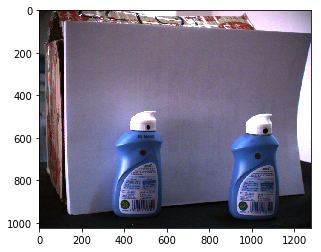

In [18]:
# 图片颜色失真的问题
import cv2   as  cv
import numpy as np
import copy
import random 
from matplotlib import pyplot as plt
# cv.imread 读取图像格式为b,g,r
img = cv.imread('pingzi_L.bmp')

#如果本身是彩图 似乎也没什么影响！
#plt显示按照 rgb次序！因此要转换
b,g,r = cv.split(img)
img_rgb = cv.merge([r,g,b])

plt.imshow(img_rgb)
plt.show()


#### 获取视差
这里需要注意的是：
- 视差的参数会极大影响到最终的结果
- 视差怎么样与具体大小对结果影响很大
- 怎样对应到现实的尺度，还需要确定一下

computing SGNM_disparity...


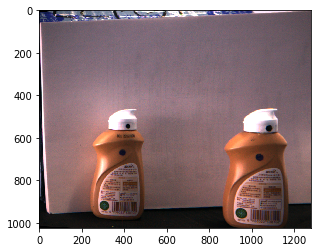

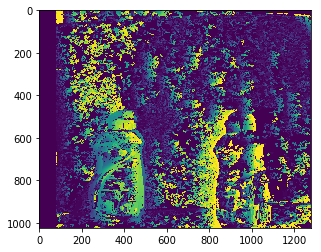

In [19]:
import numpy as np
import cv2
import time
def SGBM_update(val=0):
    global SGBM_num
    global SGBM_blockSize
    SGBM_blockSize=cv2.getTrackbarPos('blockSize', 'SGNM_disparity')
    if SGBM_blockSize % 2 == 0:
        SGBM_blockSize += 1
    if SGBM_blockSize < 5:
        SGBM_blockSize = 5
    SGBM_stereo.setBlockSize(SGBM_blockSize)
    SGBM_num=cv2.getTrackbarPos('num_disp', 'SGNM_disparity')
    num_disp = SGBM_num * 16
    SGBM_stereo.setNumDisparities(num_disp)

    SGBM_stereo.setUniquenessRatio(cv2.getTrackbarPos('unique_Ratio', 'SGNM_disparity'))
    SGBM_stereo.setSpeckleWindowSize(cv2.getTrackbarPos('spec_WinSize', 'SGNM_disparity'))
    SGBM_stereo.setSpeckleRange(cv2.getTrackbarPos('spec_Range', 'SGNM_disparity'))
    SGBM_stereo.setDisp12MaxDiff(cv2.getTrackbarPos('disp12MaxDiff', 'SGNM_disparity'))

    print('computing SGNM_disparity...')
    displ = imgR
    displ = SGBM_stereo.compute(imgL, imgR).astype(np.float32) / 16.0
    dispr = SGBM_stereo.compute(imgR, imgL).astype(np.float32) / 16.0


    return displ,dispr
#     cv2.imshow('left', imgL)
#     cv2.imshow('right', imgR)
#     cv2.imshow('SGNM_disparity', (disp - min_disp) / num_disp)

if __name__ == "__main__":
#     start = time.clock()
    SGBM_blockSize = 5 #一个匹配块的大小,大于1的奇数
    SGBM_num=5
    min_disp = 0   #最小的视差值，通常情况下为0
    num_disp =SGBM_num * 16      #192 - min_disp #视差范围，即最大视差值和最小视差值之差，必须是16的倍数。
    #blockSize = blockSize #匹配块大小（SADWindowSize），必须是大于等于1的奇数，一般为3~11
    uniquenessRatio = 6 #视差唯一性百分比， 视差窗口范围内最低代价是次低代价的(1 + uniquenessRatio/100)倍时，最低代价对应的视差值才是该像素点的视差，否则该像素点的视差为 0，通常为5~15.
    speckleRange = 10 #视差变化阈值，每个连接组件内的最大视差变化。如果你做斑点过滤，将参数设置为正值，它将被隐式乘以16.通常，1或2就足够好了
    speckleWindowSize = 100#平滑视差区域的最大尺寸，以考虑其噪声斑点和无效。将其设置为0可禁用斑点过滤。否则，将其设置在50-200的范围内。
    disp12MaxDiff = 200 #左右视差图的最大容许差异（超过将被清零），默认为 -1，即不执行左右视差检查。
    P1 = 600  #惩罚系数，一般：P1=8*通道数*SADWindowSize*SADWindowSize，P2=4*P1
    P2 = 240 #p1控制视差平滑度，p2值越大，差异越平滑

#     imgL = cv2.imread('im2.ppm')
#     imgR = cv2.imread('im6.ppm')
    imgL = iml_rectified;
    imgR = imr_rectified;

    cv2.namedWindow('SGNM_disparity')
    cv2.createTrackbar('blockSize', 'SGNM_disparity', SGBM_blockSize, 21, SGBM_update)
    cv2.createTrackbar('num_disp', 'SGNM_disparity', SGBM_num, 20, SGBM_update)
    cv2.createTrackbar('spec_Range', 'SGNM_disparity', speckleRange, 50, SGBM_update)#设置trackbar来调节参数
    cv2.createTrackbar('spec_WinSize', 'SGNM_disparity', speckleWindowSize, 200, SGBM_update)
    cv2.createTrackbar('unique_Ratio', 'SGNM_disparity', uniquenessRatio, 50, SGBM_update)
    cv2.createTrackbar('disp12MaxDiff', 'SGNM_disparity', disp12MaxDiff, 250, SGBM_update)

    SGBM_stereo = cv2.StereoSGBM_create(
        minDisparity = min_disp,  # 最小的视差值
        numDisparities = num_disp,  # 视差范围
        blockSize=SGBM_blockSize,  # 匹配块大小（SADWindowSize）
        uniquenessRatio=uniquenessRatio,  # 视差唯一性百分比
        speckleRange=speckleRange,  # 视差变化阈值
        speckleWindowSize=speckleWindowSize,
        disp12MaxDiff=disp12MaxDiff,  # 左右视差图的最大容许差异
        P1=P1,  # 惩罚系数
        P2=P2
    )
    displ,dispr = SGBM_update()
    
    plt.imshow( (imgL))
    plt.show()
#     plt.imshow( (imgR))
#     plt.show()
    plt.imshow( (displ))
    plt.show()
    # 因为右视差一定是哦有问题的
#     plt.imshow( (dispr ))
#     plt.show()

之前立体几何匹配一直有问题，

对于SGBM算法，最重要的就是参数的选取，参考https://blog.csdn.net/wwp2016/article/details/86080722

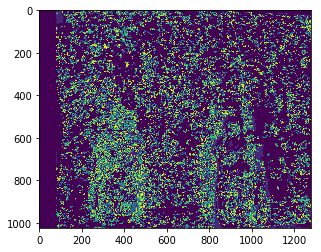

In [24]:
# 用视差获取直接深度
depth = np.ones_like(displ , dtype=np.uint8)
for i in range(height):
    for j in range(width):
        if displ[i][j]<5: ##噪音
            depth[i][j]=0
        else:
            depth[i][j] = config.cam_matrix_left[0][0]*config.baseline/(displ[i][j])
cv2.medianBlur(depth,3)
plt.imshow(depth)

![20200608094154](https://chendaxiashizhu-1259416116.cos.ap-beijing.myqcloud.com/20200608094154.png)

### 利用视差获得深度

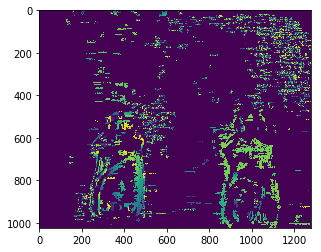

In [25]:
# 用视差获取直接深度
depth = np.ones_like(lookdispL , dtype=np.uint8)
for i in range(height):
    for j in range(width):
        if lookdispL[i][j]<5: ##噪音
            depth[i][j]=0
        else:
            depth[i][j] = config.cam_matrix_left[0][0]*config.baseline/(lookdispL[i][j])
cv2.medianBlur(depth,3)
plt.imshow(depth)

### 各个函数说明

reprojectImageTo3D:该函数将视差图，通过投影矩阵Q，得到一副映射图，图像大小与视差图相同，且每个像素具有三个通道，分别存储了该像素位置在相机坐标系下的三维点坐标在x, y, z,三个轴上的值，即每个像素的在相机坐标系下的三维坐标。参考https://blog.csdn.net/Gordon_Wei/article/details/86319058

#### 提取图片中的特征点
ORB特征点匹配，但是出现下面的问题：
- 出现错误匹配，需要剔除吗？还是直接进行计算PNP的问题？
- 下面有两种方法：KNN匹配与暴力匹配

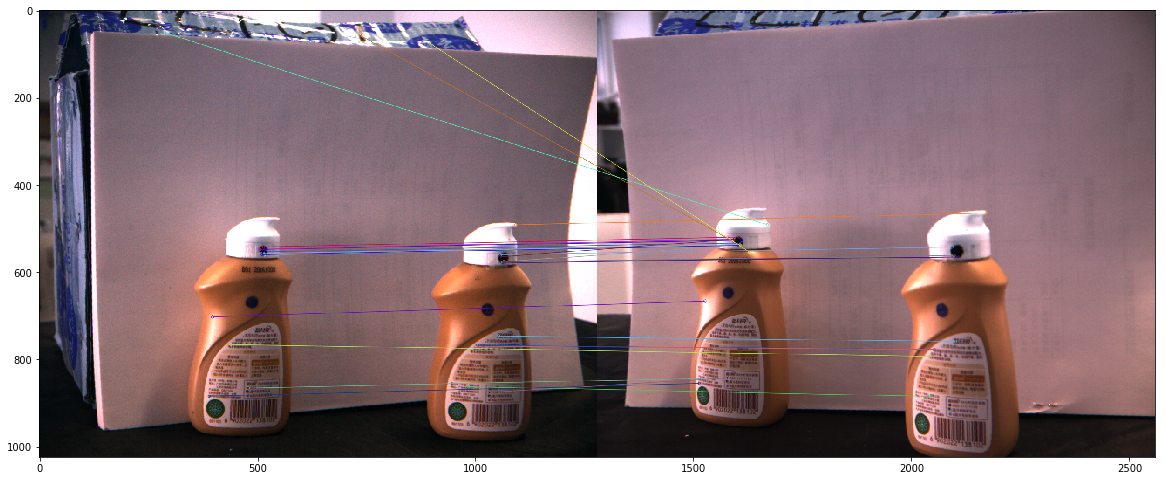

In [62]:
# coding=utf-8
import cv2
import numpy as np
 
img1 = cv2.imread('pingzi_L.bmp')
img2 = cv2.imread('pingzi_R.bmp')
# linepic2 = draw_line(img1,img2)
# plt.imshow(linepic2)
#最大特征点数,需要修改，5000太大。
orb = cv2.ORB_create(900)
 
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)
 
#提取并计算特征点
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
#knn筛选结果
matches = bf.knnMatch(des1, trainDescriptors = des2, k = 2)
# 计算距离
good = [m for (m,n) in matches if m.distance < 0.75*n.distance]
# 排序
good = sorted(good, key=lambda x: x.distance)
#查看最大匹配点数目
img3 = cv2.drawMatches(img1, kp1, img2, kp2, good, img1, flags=2)


plt.figure(figsize=(20,20))
plt.imshow(img3)


看到这里有明显的错误匹配。

- 利用RANSAC算法将不合理的匹配点去除
https://zhuanlan.zhihu.com/p/45532306
- p2p的过程可以参考项目https://github.com/MiaoDX/slambook_python
- 实际上看官方的opencv文档会更有帮助https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html

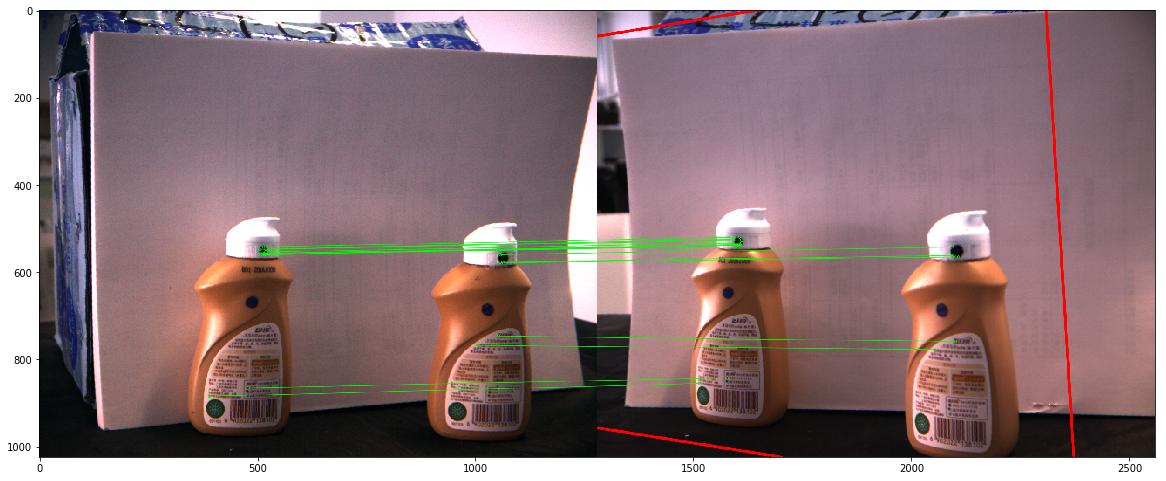

(<matplotlib.image.AxesImage at 0x12f391898>, None)

In [87]:


MIN_MATCH_COUNT = 20
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist() ## 保存这个匹配

    h,w = img1.shape[:2]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print ("Not enough matches are found - %d/%d") % (len(good),MIN_MATCH_COUNT)
    matchesMask = None

## 筛选good，并且画出来
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.figure(figsize = (20,20))
plt.imshow(img3, 'gray'),plt.show()

**下面就可以直接进行p2p的匹配**

In [92]:
"""
http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html
"""

if __name__ == "__main__":
    import numpy as np
    import cv2
    from matplotlib import pyplot as plt

    im1_file = 'pingzi_L.bmp'
    im2_file = 'pingzi_R.bmp'

    img1 = cv2.imread(im1_file, 0)  # queryImage
    img2 = cv2.imread(im2_file, 0)  # trainImage

    # Initiate SIFT detector
    # sift = cv2.SIFT()
    # fd_de = cv2.xfeatures2d.SIFT_create()
#     fd_de = cv2.xfeatures2d.SURF_create()
    fd_de = cv2.ORB_create(nfeatures=5000)

    # find the keypoints and descriptors with SIFT
    kp1, des1 = fd_de.detectAndCompute(img1, None)
    kp2, des2 = fd_de.detectAndCompute(img2, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)

    index_params_orb = dict(algorithm=6, # FLANN_INDEX_LSH <-> 6, not so sure why I can not use it
                        table_number=6,  # 12
                        key_size=12,  # 20
                        multi_probe_level=1)  # 2

    index_params_orb2 = dict(algorithm=6, # FLANN_INDEX_LSH <-> 6, not so sure why I can not use it
                        table_number=6,  # 12
                        key_size=12,  # 20
                        multi_probe_level=1)  # 2

    """
    # FAILED
    index_params_auto = dict(algorithm=255,
                             target_precision=0.9,
                             build_weight=0.01,
                             memory_weight=0,
                             sample_fraction=0.1) # FLANN_INDEX_AUTOTUNED <-> 255
    # flann = cv2.FlannBasedMatcher(index_params_auto, search_params)
    """

    search_params = dict(checks=50)  # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.FlannBasedMatcher(index_params_orb, search_params)
    #flann = cv2.FlannBasedMatcher(index_params_orb2, search_params)
    #matches_HAMMING = flann.match(des1, des2) # for ORB like

    matches = flann.knnMatch(des1, des2, k=2)

    # Need to draw only good matches, so create a mask
    matchesMask = [[0, 0] for i in range(len(matches))]



    matches_good = []
    # ratio test as per Lowe's paper
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7 * n.distance:
            matchesMask[i] = [1, 0]
            matches_good.append(m)

    draw_params = dict(matchColor=(0, 255, 0),
                       singlePointColor=(255, 0, 0),
                       matchesMask=matchesMask,
                       flags=0)

    print("Matches with ratio test:{}->{}".format(len(matches), len(matches_good)))

    img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)
    #img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches_good, None, flags=2)


    plt.imshow(img3, ), plt.show()

error: OpenCV(4.2.0) /Users/travis/build/skvark/opencv-python/opencv/modules/flann/src/miniflann.cpp:315: error: (-210:Unsupported format or combination of formats) in function 'buildIndex_'
> type=0
> 

- 也可以采用暴力匹配

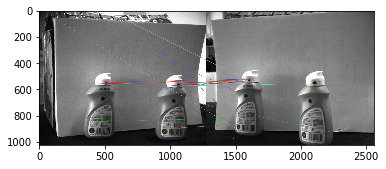

In [34]:
import cv2
 
"""
orb特征检测和匹配
    两幅图片分别是 乐队的logo 和包含该logo的专辑封面
    利用orb进行检测后进行匹配两幅图片中的logo
    
"""
# 按照灰度图像的方式读入两幅图片
img1 = cv2.imread("pingzi_L.bmp", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("pingzi_R.bmp", cv2.IMREAD_GRAYSCALE)
 
# 创建ORB特征检测器和描述符
orb = cv2.ORB_create()
# 对两幅图像检测特征和描述符
keypoint1, descriptor1 = orb.detectAndCompute(img1, None)
keypoint2, descriptor2 = orb.detectAndCompute(img2, None)
"""
keypoint 是一个包含若干点的列表
descriptor 对应每个点的描述符 是一个列表， 每一项都是检测到的特征的局部图像
检测的结果是关键点
计算的结果是描述符
可以根据监测点的描述符 来比较检测点的相似之处
"""
# 获得一个暴力匹配器的对象
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# 利用匹配器 匹配两个描述符的相近成都
maches = bf.match(descriptor1, descriptor2)
# 按照相近程度 进行排序
maches = sorted(maches, key=lambda x: x.distance)
# 画出匹配项
img3 = cv2.drawMatches(img1, keypoint1, img2, keypoint2, maches[:30], img2, flags=2)
plt.imshow(img3)
# cv2.imshow("matches", img3)
# cv2.waitKey()
# cv2.destroyAllWindows()

### 选取瓶子上的点进行测距
本来设想用深度计算，但是计算深度图出错，所以换一种其他的方法。选取「slam十四讲」中的「三角测量法」。
选取瓶子中黑色圆点的坐标(u,v)，利用三角测量法计算距离。

In [28]:
# # 点击图片中的点，打印图片对应点在像素坐标系中的坐标
# import cv2
# import numpy as np
# # imgL = cv2.imread('im2.ppm')
# img = cv2.imread('pingzi_R.bmp')
# a =[]
# b = []
# def on_EVENT_LBUTTONDOWN(event, x, y,flags, param):
#     if event == cv2.EVENT_LBUTTONDOWN:
#         xy = "%d,%d" % (x, y)
#         a.append(x)
#         b.append(y)
#         cv2.circle(img, (x, y), 1, (255, 0, 0), thickness=-1)
#         cv2.putText(img, xy, (x, y), cv2.FONT_HERSHEY_PLAIN,
#                     1.0, (0, 0, 0), thickness=1)
#         print(y,x)
#         cv2.imshow("image", img)

# cv2.namedWindow("image")
# cv2.setMouseCallback("image", on_EVENT_LBUTTONDOWN)
# cv2.imshow("image", img)
# cv2.waitKey(0)
# print(a[0],b[0])

# img[b[0]:b[1],a[0]:a[1],:] = 0   #注意是 行，列（y轴的，X轴）
# cv2.imshow("image", img)
# cv2.waitKey(0)
# print(a,b)

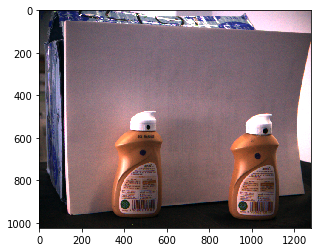

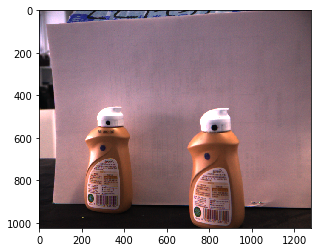

In [29]:
imgL = cv2.imread('pingzi_L.bmp')
imgR = cv2.imread('pingzi_R.bmp')
plt.imshow(imgL)
plt.show()
plt.imshow(imgR)
plt.show()

In [16]:
list = np.array([])


SyntaxError: invalid syntax (<ipython-input-16-48a5480a0e0b>, line 1)

In [5]:
# 左右图的像素点坐标
# zuo y,x
n1 = np.array([[553 ,515],
[670, 490],
[570, 1067],
[689 ,1031]])
n1 = n1+10
# right
n2 = np.array([[533, 326],
[650 ,301],
[554, 827],
[692 ,792]])


def tocam(K , tmp):
    fx = K[0][0]
    fy = K[1][1]
    cx = K[0][2]
    cy = K[1][2]
    u = tmp[0]
    v = tmp[1]
    x = (u-cx)/fx
    y = (v-cy)/fy
    tp = np.array([[x,y,1]])
    tp2 = np.transpose(tp)
    return tp2
tocam(config.cam_matrix_left , n1[1])*100
# pp =  tocam(config.cam_matrix_left , n1[3])*100

def lidaishu(tmp):
    
    f0 = tmp[0][0]
    f1 = tmp[1][0]
    f2 = tmp[2][0]
    
    out = np.array([[0,-f2,f1],
                   [f2 , 0, -f0],
                   [-f1 , f0 , 0]])
    return out
def zuixiaoercheng(A,B):
    tp1 = np.dot(np.transpose(A) , A)
    tp2 = np.linalg.inv(tp1)
    tp3 = np.dot(tp2,np.transpose(A))
    tp4 = np.dot(tp3 , -B)
    
#     tp1 = np.linalg.solve(A,-B)
    return tp4
tocam(config.cam_matrix_left , n1[1])*100


array([[  0.77139],
       [ -1.00062],
       [100.     ]])

In [8]:
R = config.R
t = config.T
for i in range(1):
    p1_uv = n1[i]
    p2_uv = n2[i]
    p1 = tocam(config.cam_matrix_left , p1_uv)
    p2 = tocam(config.cam_matrix_right , p2_uv)
    p1_ = lidaishu(p1)
    tp1 = np.dot(p1_ , R)
    A = np.dot(tp1 , p2)
    B = np.dot(p1_,t)
    print(A)
    print(B)
    s2 = zuixiaoercheng(A,B)
    
    A = -p1
    B = s2*np.dot(R,p2)+t
    s1 = zuixiaoercheng(A,B)
    print(s1,s2)

[[0.09796]
 [0.53036]
 [0.00372]]
[[   7.41716]
 [-291.37978]
 [   0.80358]]
[[514.52098]] [[528.74117]]


便找到了所有的距离，单位是mm。距离为50mm，相对来说比较合理。

In [12]:
s2*np.dot(R,p2)+t - s1*p1

array([[-10.93663],
       [-59.21249],
       [ -0.41517]])

### 测距结果
实际上这个结果是不怎么好的

In [16]:

[[505.27209736]] [[518.45745147]]
[[496.33396279]] [[525.10810405]]
[[489.92618696]] [[520.9013579]]
[[473.46269727]] [[520.31709609]]

# +1
[[505.47737869]] [[518.72081243]]
[[496.52069189]] [[525.36200674]]
[[490.07245931]] [[521.16867244]]
[[473.5977723]] [[520.57774345]]

# +10
[[507.28486502]] [[521.06072213]]
[[498.16011302]] [[527.61586103]]
[[491.35189698]] [[523.54618965]]
[[474.77908216]] [[522.8977657]]

TypeError: list indices must be integers or slices, not list

In [10]:
n1 = n1+1

In [22]:
10000*8.29e-6

0.0829

In [37]:
alpha = config.cam_matrix_left[0][0]/17.5
1280/alpha
# 1/config.cam_matrix_left[0][0]

10.376786886657337

In [34]:
height

1024

In [36]:
width

1280